## Install the package dependencies before running this notebook

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import random

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

C:\Users\14388\anaconda3\envs\torchenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [2]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):

    
    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[:int(n * 0.95)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n * 0.95)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[int(n * 0.95):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.95):]
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

In [3]:
# intialize a dataset
def get_data_loader(city = 'austin', batch_size = 20):
    train_dataset  = ArgoverseDataset(city = city, split = 'train')
    val_dataset = ArgoverseDataset(city = city, split = 'val')

    train_loader = DataLoader(train_dataset,batch_size=batch_size)
    val_loader = DataLoader(val_dataset,batch_size=batch_size)
    return train_dataset, val_dataset, train_loader, val_loader

In [4]:
train_dataset, val_dataset, train_loader, val_loader = get_data_loader(city = 'austin', batch_size = 20)

In [5]:
len(val_dataset)

2153

In [6]:
len(train_dataset)

40888

## models

In [8]:
from torch import nn, optim

# model1: EncoderDecoder
class EncoderDecoder(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(100, 64),
            nn.LogSigmoid(),
            nn.Linear(64, 32),
            nn.LogSigmoid(),
            nn.Linear(32, 32)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.LogSigmoid(),
            nn.Linear(64, 120),
            nn.LogSigmoid(),
            nn.Linear(120, 120)
        )
        
    def forward(self, x):
        x = x.reshape(-1, 100).float()
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.reshape(-1, 60, 2)
        return x.float()

In [9]:
# model2: MLP
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        self.mlp = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 120)
        )
    
    def forward(self, x):
        x = x.reshape(-1, 100).float()
        x = self.mlp(x)
        x = x.reshape(-1, 60, 2)
        return x.float()

In [10]:
# model, optimizer, loss
model_encdoc = EncoderDecoder()
opt = optim.Adam(model_encdoc.parameters(), lr=1e-3)
loss_func = nn.MSELoss()

In [11]:
def train_epochs(model, train_loader, loss_func, opt, epochs = 10):
    train_losses = []
    for epoch in range(epochs):

        total_loss = 0
        for i_batch, sample_batch in enumerate(train_loader):
            inp, out = sample_batch
            out = out.float()
            preds = model(inp)
            loss = loss_func(preds, out) # MSE
            #loss = torch.sqrt(loss_func(preds, out)) # RMSE

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()

        print('epoch {} trian loss: {}'.format(epoch, total_loss / len(train_dataset)))
        train_losses.append(total_loss / len(train_dataset))
    return train_losses

In [12]:
def val_loss(model, val_loader, loss_func, opt):
    val_loss = 0
    for i_batch, sample_batch in enumerate(val_loader):
        inp, out = sample_batch
        out = out.float()
        preds = model(inp)
        loss = loss_func(preds, out) # MSE
        #loss = torch.sqrt(loss_func(preds, out)) # RMSE

        val_loss += loss.item()
    print('val loss: {}'.format(val_loss / len(val_dataset)))

In [13]:
def train_city(city, batch_size, epochs, model):
    # data loader
    train_dataset, val_dataset, train_loader, val_loader = get_data_loader(city = city, batch_size = batch_size)
    
    # model, optimizer, loss
    model_encdoc = model
    opt = optim.Adam(model_encdoc.parameters(), lr=1e-3)
    loss_func = nn.MSELoss()
    
    # train
    train_losses = train_epochs(model_encdoc, train_loader, loss_func, opt, epochs = epochs)
    
    # evaluate
    # val_loss(model_encdoc, val_loader, loss_func, opt)
    return model_encdoc, train_losses

## Training

In [93]:
# model, optimizer, loss
mlp = MLP()
opt = optim.Adam(model_encdoc.parameters(), lr=1e-3)
loss_func = nn.MSELoss()

In [79]:
for i_batch, sample_batch in enumerate(train_loader):
    inp, out = sample_batch
    out = out.float()
    preds = mlp(inp)
    print(inp.shape)
    print(preds.shape)
    print(out.shape)
    loss = loss_func(preds, out)
    print(loss)
    break

torch.Size([20, 50, 2])
torch.Size([20, 60, 2])
torch.Size([20, 60, 2])
tensor(3108324.7500, grad_fn=<MseLossBackward0>)


epoch 0 trian loss: 393.38518951839956
epoch 1 trian loss: 22.280564000848642
epoch 2 trian loss: 24.31566081441701
epoch 3 trian loss: 22.824640997653603
epoch 4 trian loss: 21.277399614304624
epoch 5 trian loss: 18.76080187545833
epoch 6 trian loss: 21.227698706572966
epoch 7 trian loss: 17.582340625605454
epoch 8 trian loss: 8.642059239592951
epoch 9 trian loss: 14.439032911577936
val loss: 38.41288165541178


Text(0, 0.5, 'MSE')

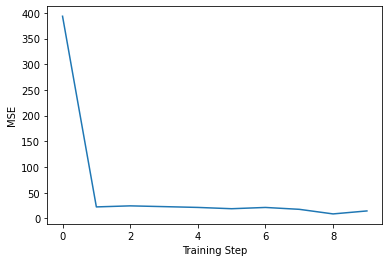

In [15]:
# austin
model_austin = MLP()
model_austin, train_losses = train_city('austin', batch_size = 64, epochs = 10, model = model_austin)
val_loss(model_austin, val_loader, loss_func, opt)
plt.plot(train_losses)
plt.xlabel('Training Step')
plt.ylabel('MSE')

epoch 0 trian loss: 2103.8864886306824
epoch 1 trian loss: 60.92564847823389
epoch 2 trian loss: 92.2322881762423
epoch 3 trian loss: 78.8894745302956
epoch 4 trian loss: 51.10733285096732
epoch 5 trian loss: 103.62380479735373
epoch 6 trian loss: 55.32301306533291
epoch 7 trian loss: 64.08888214624831
epoch 8 trian loss: 60.64913455736985
epoch 9 trian loss: 56.16205512733288
val loss: 405.1633360880893


Text(0, 0.5, 'MSE')

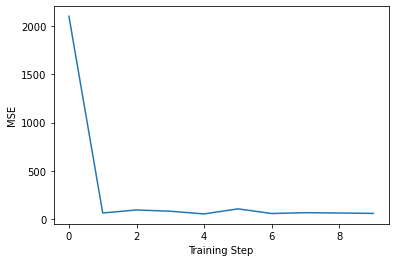

In [16]:
# miami
model = MLP()
model_miami, train_losses = train_city('miami', batch_size = 64, epochs = 10, model = model)
val_loss(model_miami, val_loader, loss_func, opt)
plt.plot(train_losses)
plt.xlabel('Training Step')
plt.ylabel('MSE')

epoch 0 trian loss: 1602.5606804274692
epoch 1 trian loss: 22.532425167088967
epoch 2 trian loss: 30.095512564787306
epoch 3 trian loss: 30.924761208459792
epoch 4 trian loss: 31.69064628856333
epoch 5 trian loss: 27.292811459231764
epoch 6 trian loss: 27.77358005742368
epoch 7 trian loss: 25.882186400029692
epoch 8 trian loss: 23.82995995223184
epoch 9 trian loss: 22.84970122329691
val loss: 18844.290227299116


Text(0, 0.5, 'MSE')

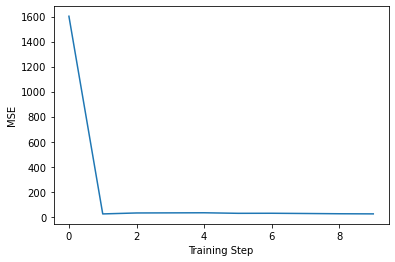

In [17]:
# pittsburgh
mlp = MLP()
model_pittsburgh, train_losses = train_city('pittsburgh', batch_size = 64, epochs = 10, model = mlp)
val_loss(model_pittsburgh, val_loader, loss_func, opt)
plt.plot(train_losses)
plt.xlabel('Training Step')
plt.ylabel('MSE')

epoch 0 trian loss: 6248.036561548349
epoch 1 trian loss: 24.413187497563847
epoch 2 trian loss: 29.554629057733262
epoch 3 trian loss: 33.26314932342332
epoch 4 trian loss: 34.376461192507776
epoch 5 trian loss: 53.55130006674101
epoch 6 trian loss: 59.24429132009621
epoch 7 trian loss: 57.90695196699196
epoch 8 trian loss: 57.08381811659575
epoch 9 trian loss: 55.79578171119697
val loss: 54492.379673711104


Text(0, 0.5, 'MSE')

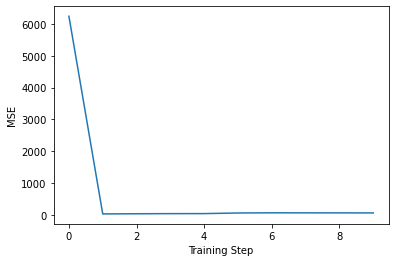

In [18]:
# dearborn
mlp = MLP()
model_dearborn, train_losses = train_city('dearborn', batch_size = 64, epochs = 10, model = mlp)
val_loss(model_dearborn, val_loader, loss_func, opt)
plt.plot(train_losses)
plt.xlabel('Training Step')
plt.ylabel('MSE')

epoch 0 trian loss: 1856.8010788740091
epoch 1 trian loss: 13.370718300494167
epoch 2 trian loss: 14.291630029351808
epoch 3 trian loss: 15.78370055226845
epoch 4 trian loss: 22.334707065702442
epoch 5 trian loss: 21.26473578070736
epoch 6 trian loss: 34.59853002540381
epoch 7 trian loss: 27.782538933288418
epoch 8 trian loss: 15.543214801332297
epoch 9 trian loss: 19.193987536444354
val loss: 34312.580962610315


Text(0, 0.5, 'MSE')

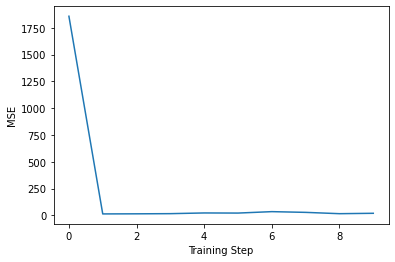

In [19]:
# washington_dc
mlp = MLP()
model_washington_dc, train_losses = train_city('washington-dc', batch_size = 64, epochs = 10, model = mlp)
val_loss(model_washington_dc, val_loader, loss_func, opt)
plt.plot(train_losses)
plt.xlabel('Training Step')
plt.ylabel('MSE')

epoch 0 trian loss: 404.92356977871407
epoch 1 trian loss: 7.543140307631518
epoch 2 trian loss: 7.483508304662374
epoch 3 trian loss: 8.483040451560322
epoch 4 trian loss: 8.224717536706837
epoch 5 trian loss: 7.339384880207728
epoch 6 trian loss: 8.894531509736773
epoch 7 trian loss: 10.818123884057373
epoch 8 trian loss: 7.384501538382097
epoch 9 trian loss: 13.783410442339607
val loss: 82.84196433188248


Text(0, 0.5, 'MSE')

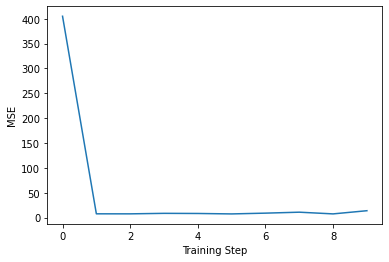

In [20]:
# palo_alto
mlp = MLP()
model_palo_alto, train_losses = train_city('palo-alto', batch_size = 64, epochs = 10, model = mlp)
val_loss(model_palo_alto, val_loader, loss_func, opt)
plt.plot(train_losses)
plt.xlabel('Training Step')
plt.ylabel('MSE')

## Make Prediction

In [21]:
cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
models = [model_austin, model_miami, model_pittsburgh, model_dearborn, model_washington_dc, model_palo_alto]

In [22]:
def predict_test(city, model):
    test_dataset = get_city_trajectories(city = city, split = 'test')[0]
    test_dataset = torch.from_numpy(test_dataset)
    pred = model(test_dataset).reshape(-1, 120)
    return pd.DataFrame(pred.detach().numpy())

In [23]:
columns =['ID'] + ['v'+str(i) for i in range(120)]

In [24]:
def predict_all(cities, models):
    out = predict_test(cities[0], models[0]).reset_index()
    out.columns = columns
    out['ID'] = out['ID'].astype(str) + '_' + cities[0]
    
    for city, model in zip(cities[1:], models[1:]):
        temp = predict_test(city, model).reset_index()
        temp.columns = columns
        temp['ID'] = temp['ID'].astype(str) + '_' + city
        out = pd.concat([out, temp])
    
    return out        

In [25]:
test_output = predict_all(cities, models)

In [26]:
test_output.to_csv('test_output.csv', index=False)

In [27]:
test_output

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
0,0_austin,-12.274271,-569.611877,-9.483233,-571.871765,-10.320328,-574.173218,-13.976591,-569.374512,-14.947170,...,-43.458305,-567.218750,-42.077290,-567.922791,-40.767471,-569.543518,-46.848164,-568.430298,-44.021938,-571.277832
1,1_austin,-349.606873,6.513977,-355.098389,5.693699,-354.600372,5.708442,-352.738342,7.262376,-345.688843,...,-351.474823,-17.969404,-348.948486,-18.305851,-345.062317,-16.589478,-352.807648,-19.938955,-348.813934,-20.222277
2,2_austin,52.238003,-249.850082,51.633129,-249.196198,53.036709,-249.447632,51.939991,-249.660233,51.465332,...,55.204639,-250.913895,55.172924,-251.189423,55.601936,-251.106400,54.794281,-252.216370,54.491856,-251.440231
3,3_austin,-103.546249,1795.338257,-108.782494,1792.521240,-116.528603,1801.284058,-111.055649,1799.593628,-108.453461,...,-99.383545,1819.583374,-101.993034,1814.299072,-101.187271,1815.249634,-91.823990,1811.967407,-101.854477,1821.565430
4,4_austin,1206.343750,-638.701965,1208.980347,-636.604797,1212.035278,-641.642883,1206.955688,-644.042725,1210.059937,...,1246.103882,-647.595886,1239.788208,-649.550720,1237.999878,-647.307922,1242.427124,-651.629700,1240.551514,-648.237976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1681,1681_palo-alto,-1397.602051,-455.680054,-1390.574829,-459.671051,-1402.632202,-460.098877,-1409.098877,-456.608734,-1394.320801,...,-1396.992554,-453.406830,-1404.474854,-451.226959,-1400.284668,-457.384674,-1398.872681,-453.254486,-1403.990601,-452.808777
1682,1682_palo-alto,126.885231,-26.117283,126.336540,-27.090616,125.994774,-28.276144,127.263100,-28.084583,127.223450,...,127.767677,-25.629829,126.694595,-26.520344,127.102882,-26.676155,125.338959,-26.133646,127.912430,-25.604546
1683,1683_palo-alto,-1423.200684,2120.553223,-1429.093384,2129.411621,-1436.959229,2111.875000,-1431.079834,2120.131836,-1422.234253,...,-1435.731201,2137.077393,-1444.496948,2137.065918,-1438.054565,2132.393311,-1436.953003,2116.832520,-1442.351440,2130.452881
1684,1684_palo-alto,1072.889404,1352.051636,1066.386108,1363.117432,1063.916626,1357.631592,1061.698608,1354.566650,1068.734497,...,1066.769409,1349.325317,1063.336914,1350.332520,1076.366455,1355.467041,1065.059692,1338.056519,1072.017090,1354.048950


## Sample a batch of data and visualize 

In [112]:
train_dataset, val_dataset, train_loader, val_loader = get_data_loader(city = 'austin', batch_size = 10)

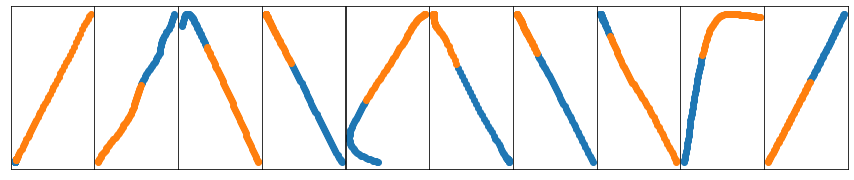

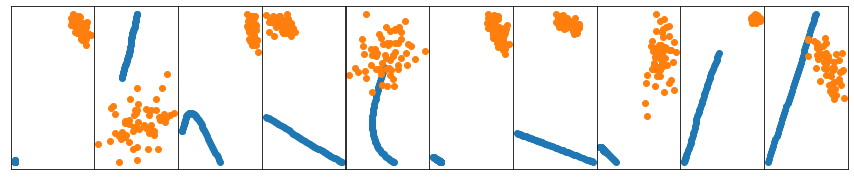

In [123]:
import matplotlib.pyplot as plt
import random


def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])

        
for i_batch, sample_batch in enumerate(train_loader):
    if i_batch < 5: continue
    inp, out = sample_batch
    pred = model_austin(inp).detach()
    show_sample_batch(sample_batch)
    show_sample_batch([inp, pred])
    #print(sample_batch)
    break